In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.model_selection import train_test_split

# Load the dataset 
data = pd.read_csv('processed_data_Encoding.csv')

# Separate features and target
X = data.drop('y', axis=1) 
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: Check the shape of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (36168, 49)
X_test shape: (9042, 49)


In [3]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print("Original class distribution (train):", y_train.value_counts())
print("Resampled class distribution (train):", y_train_res.value_counts())

Original class distribution (train): y
0    31972
1     4196
Name: count, dtype: int64
Resampled class distribution (train): y
0    31972
1    31972
Name: count, dtype: int64


In [4]:
# Specify numerical columns for scaling and PCA
numerical_cols = ['age', 'balance', 'campaign', 'previous','balance_no_previous'] 

# Apply scaling only to the specified numerical columns
scaler = StandardScaler()
X_train_scaled = X_train_res.copy()  # Copy to preserve other columns
X_test_scaled = X_test.copy()  # Copy to preserve other columns

# Scale only the numerical columns
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_res[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [5]:
# Apply PCA only to the scaled numerical columns
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled[numerical_cols])
X_test_pca = pca.transform(X_test_scaled[numerical_cols])

# Drop original numerical columns from the data
X_train_scaled.drop(columns=numerical_cols, inplace=True)
X_test_scaled.drop(columns=numerical_cols, inplace=True)

# Add the PCA components to the scaled data
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Add PCA components as new columns
pca_columns = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]
X_train_scaled[pca_columns] = X_train_pca
X_test_scaled[pca_columns] = X_test_pca

Epoch 1/20, Loss: 0.2813, Accuracy: 0.8925
Epoch 2/20, Loss: 0.2403, Accuracy: 0.9101
Epoch 3/20, Loss: 0.2294, Accuracy: 0.9136
Epoch 4/20, Loss: 0.2242, Accuracy: 0.9155
Epoch 5/20, Loss: 0.2203, Accuracy: 0.9164
Epoch 6/20, Loss: 0.2172, Accuracy: 0.9176
Epoch 7/20, Loss: 0.2160, Accuracy: 0.9179
Epoch 8/20, Loss: 0.2138, Accuracy: 0.9186
Epoch 9/20, Loss: 0.2117, Accuracy: 0.9194
Epoch 10/20, Loss: 0.2107, Accuracy: 0.9198
Epoch 11/20, Loss: 0.2093, Accuracy: 0.9207
Epoch 12/20, Loss: 0.2082, Accuracy: 0.9209
Epoch 13/20, Loss: 0.2068, Accuracy: 0.9213
Epoch 14/20, Loss: 0.2055, Accuracy: 0.9216
Epoch 15/20, Loss: 0.2053, Accuracy: 0.9215
Epoch 16/20, Loss: 0.2041, Accuracy: 0.9223
Epoch 17/20, Loss: 0.2029, Accuracy: 0.9228
Epoch 18/20, Loss: 0.2025, Accuracy: 0.9230
Epoch 19/20, Loss: 0.2017, Accuracy: 0.9236
Epoch 20/20, Loss: 0.2008, Accuracy: 0.9239


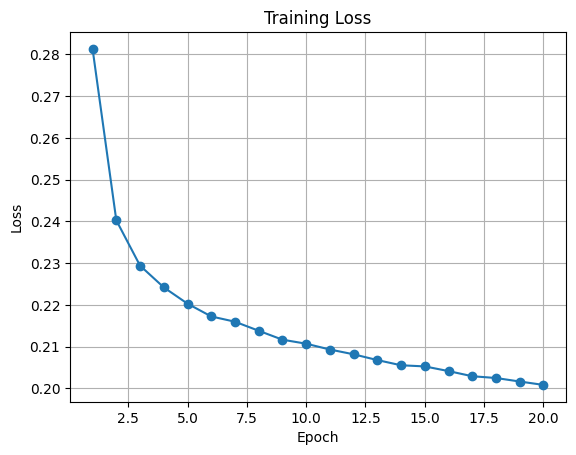

Training Accuracy: 0.9255285875140749
Test Accuracy: 0.8748064587480646
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7949
           1       0.47      0.31      0.37      1093

    accuracy                           0.87      9042
   macro avg       0.69      0.63      0.65      9042
weighted avg       0.86      0.87      0.86      9042



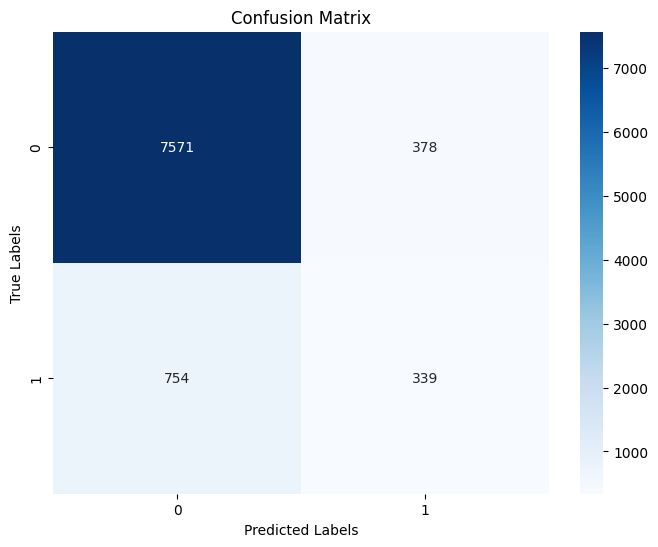

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
torch.manual_seed(42)

# Convert preprocessed DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                         # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define model parameters
input_size = X_train_scaled.shape[1]  # Number of features
hidden_size = 64               # Number of neurons in the hidden layer
output_size = len(y_train.unique())  # Number of output classes


# Initialize the model
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training the model
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_accuracy = correct / total
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Evaluation
model.eval()
y_train_pred = []
y_train_true = []
y_test_pred = []
y_test_true = []

# Training Accuracy
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(y_batch.cpu().numpy())

print("Training Accuracy:", accuracy_score(y_train_true, y_train_pred))

# Test Accuracy
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(y_batch.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))

# Classification Report for Test Data
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# # Save the model
# torch.save(model.state_dict(), 'neural_net_model.pth')
# print("Model saved as 'neural_net_model.pth'")


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    return accuracy_score(y_true, y_pred), y_true, y_pred

# Train the model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)
            
            epoch_loss += loss.item()

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        # Validate the model
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

# Hyperparameter tuning
def tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_accuracy = 0
    best_hyperparameters = {}

    # Split training data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

     # Apply SMOTE on the training data to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_split_resampled, y_train_split_resampled = smote.fit_resample(X_train_split, y_train_split)


    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Create DataLoaders
                train_dataset = TensorDataset(torch.tensor(X_train_split.values, dtype=torch.float32),  # Convert to NumPy array
                               torch.tensor(y_train_split.values, dtype=torch.long))  # Convert to NumPy array
                val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32),  # Convert to NumPy array
                             torch.tensor(y_val.values, dtype=torch.long))  # Convert to NumPy array
                test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32),  # Convert to NumPy array
                              torch.tensor(y_test.values, dtype=torch.long))  # Convert to NumPy array

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Initialize the model
                model = NeuralNet(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=2).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device)

                # Evaluate on validation set
                val_accuracy, _, _ = evaluate_model(model, val_loader, device)

                # Update best hyperparameters
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_hyperparameters = {'hidden_size': hidden_size, 'lr': lr, 'batch_size': batch_size}
                    # Save the best model
                    torch.save(model.state_dict(), "best_NN_model.pth")

                print(f"Hidden Size: {hidden_size}, LR: {lr}, Batch Size: {batch_size}, Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on the test set
    best_model = NeuralNet(input_size=X_train.shape[1], hidden_size=best_hyperparameters['hidden_size'], output_size=2).to(device)
    best_model.load_state_dict(torch.load("best_NN_model.pth"))
    test_accuracy, y_true, y_pred = evaluate_model(best_model, test_loader, device)

    # Print metrics
    print(f"Best Hyperparameters: {best_hyperparameters}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")

    # Classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_true, y_pred))

# Example hyperparameter values
hidden_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Assuming X_train, y_train, X_test, y_test are already prepared and normalized
tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes)


Early stopping triggered after 8 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 16, Val Accuracy: 0.8872
Early stopping triggered after 7 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 32, Val Accuracy: 0.8872
Early stopping triggered after 11 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 64, Val Accuracy: 0.8908
Early stopping triggered after 14 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 16, Val Accuracy: 0.8929
Early stopping triggered after 12 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 32, Val Accuracy: 0.8893
Hidden Size: 32, LR: 0.001, Batch Size: 64, Val Accuracy: 0.8869
Early stopping triggered after 9 epochs.
Hidden Size: 32, LR: 0.0001, Batch Size: 16, Val Accuracy: 0.8880
Early stopping triggered after 11 epochs.
Hidden Size: 32, LR: 0.0001, Batch Size: 32, Val Accuracy: 0.8813
Hidden Size: 32, LR: 0.0001, Batch Size: 64, Val Accuracy: 0.8825
Early stopping triggered after 14 epochs.
Hidden Size: 64, LR: 0.01, Batch Size: 16, Val Accuracy: 0.8872
Early stopping tri

C:\Users\wasif\AppData\Local\Temp\ipykernel_26884\913707084.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_NN_model.pth"))

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to calculate and plot ROC-AUC
def calculate_roc_auc(model, data_loader, device, plot_roc=False):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            y_true.extend(y_batch.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_probs) if len(set(y_true)) > 1 else None
    
    # Optionally plot ROC curve
    if plot_roc and roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.grid()
        plt.show()
    
    return roc_auc




C:\Users\wasif\AppData\Local\Temp\ipykernel_26884\1011457412.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_NN_model.pth"))


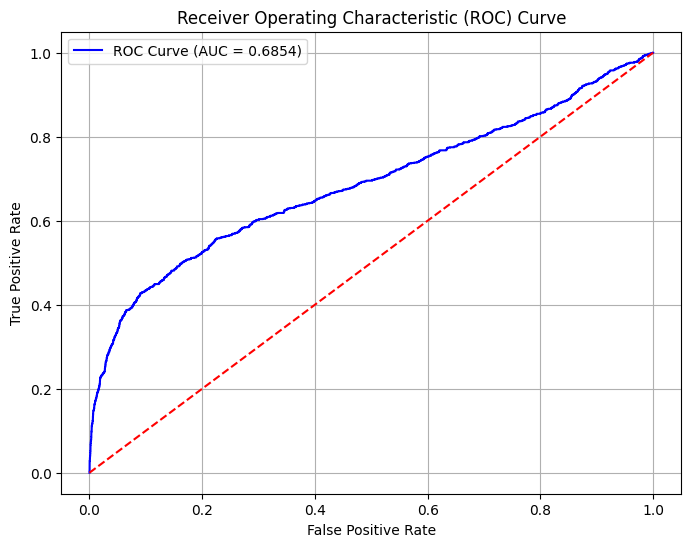

Test ROC-AUC: 0.6854


In [11]:
# Define the model architecture with correct hidden size
best_hidden_size = 64  # Replace with the hidden size used during training
best_model = NeuralNet(input_size=X_train.shape[1], hidden_size=best_hidden_size, output_size=2).to(device)

# Load the best model from saved file
best_model.load_state_dict(torch.load("best_NN_model.pth"))

# Define the test_loader
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32),
                              torch.tensor(y_test.values, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate and plot ROC-AUC
roc_auc = calculate_roc_auc(best_model, test_loader, device, plot_roc=True)
print(f"Test ROC-AUC: {roc_auc:.4f}")
